In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer

In [80]:
d = (pd
     .read_csv('../data/tangramsSequential.csv')
     .query('correct == 1')
     .groupby(['roundNum','gameid', 'intendedObj', 'occurrenceNum'])['contents']
     .apply(' '.join)
     .reset_index())

In [81]:
d.head()

,roundNum,gameid,intendedObj,occurrenceNum,contents
0,1,0057-414228f8-c268-40d6-9349-b35df4f080d9,B,1,"Hi Hello Looking for a diamond at the top, tri..."
1,1,0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7,J,1,diamond on a self
2,1,0723-9b842133-a121-4b53-9c37-784e6023e022,I,1,hi there hey what am i looking for here? click...
3,1,1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954,C,1,it looks like a person holding up two arms
4,1,1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c,L,1,Hello squatting and facing right


In [82]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, random_state=42,
                                            max_iter=5, tol=None)),
])

Let's train on all descriptions from one round and see how well we can perform task on other rounds

In [103]:
train_num = 6
test_num = 4
output = np.zeros([6,6])
mlb = MultiLabelBinarizer()
for train_num in range(1,7):
    for test_num in range(1,7) :
        text_clf.fit(d[d['occurrenceNum']==train_num]['contents'], d[d['occurrenceNum']==train_num]['intendedObj'])
        predicted = text_clf.decision_function(d[d['occurrenceNum']==test_num]['contents'])
        ytrue = mlb.fit_transform(d[d['occurrenceNum']==test_num]['intendedObj'])
        output[train_num-1, test_num-1] = roc_auc_score(ytrue, predicted, average='micro')

Text(33,0.5,'Train')

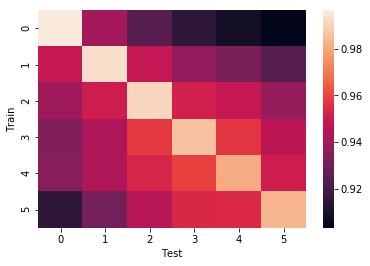

In [104]:
fig = sns.heatmap(output)
plt.xlabel("Test")
plt.ylabel("Train")

In [105]:
output

array([[0.99652979, 0.94142964, 0.92478071, 0.91481817, 0.90826236,
        0.90319342],
       [0.94880841, 0.99345461, 0.94824657, 0.93732609, 0.93254751,
        0.92406401],
       [0.94027865, 0.95033938, 0.99124016, 0.95204303, 0.94850084,
        0.93852797],
       [0.93397666, 0.94326888, 0.95763382, 0.98638893, 0.95680715,
        0.94685076],
       [0.93476648, 0.94345337, 0.95319147, 0.95930708, 0.9810795 ,
        0.95026786],
       [0.91513341, 0.93075817, 0.94535855, 0.95401674, 0.95458569,
        0.98337466]])

TODO:
* hold out participants within round (e.g. another way of looking at arbitrariness analysis: how well can we do the task on novel person A given only data from other speakers)
* instead of svm, train pytorch bag of words embedding initialized with word2vec... 
* then check whether you predict person A's round 6 better or worse after training on their rounds 1-5.